In [1]:
using LinearAlgebra, Statistics
using Distributions, Plots, QuadGK, Polynomials, Interpolations
using DataFrames,RDatasets, DataFramesMeta, CategoricalArrays, Query, VegaLite
using ForwardDiff, Zygote, Optim, JuMP, Ipopt, BlackBoxOptim, Roots, NLsolve, LeastSquaresOptim
using Optim: converged, maximum, maximizer, minimizer, iterations
using GLM
using RegressionTables
gr(fmt = :png)

Plots.GRBackend()

In [2]:
#Part A
#1
function cal_Gini(income_arr)
    ## first sort
    sorted_arr = copy(income_arr)
    sort!(sorted_arr)
    n, = size(sorted_arr)
    ## formula from https://en.wikipedia.org/wiki/Gini_coefficient#Calculation
    coef_ = (2. / n)
    const_ = (n + 1.) / n
    weighted_sum = sum((i+1)*yi for (i, yi) in enumerate(sorted_arr))
    Lorenz_curve = cumsum(sorted_arr)/sum(sorted_arr);
    return coef_*weighted_sum/(sum(sorted_arr)) - const_ , 100Lorenz_curve
end

cal_Gini (generic function with 1 method)

In [5]:
#2
function gen_income(d::Distribution{Univariate,Continuous}, N::Integer)
    return rand(d,N)
end

gen_income (generic function with 1 method)

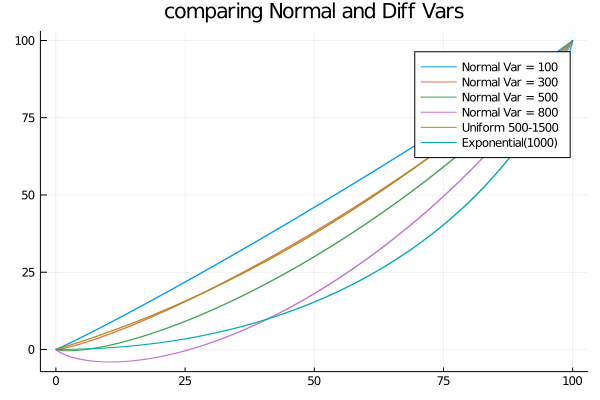

In [6]:
#3  -> the more Variance, The more inequality and Gini Coeff
N = 10_000_000
x= range(0,100,length=N)
arr = gen_income(Normal(1000,100),N)
Gi_co1, L_curve1 = cal_Gini(arr)
plot(x , L_curve1 ,label="Normal Var = 100",title=("comparing Normal and Diff Vars"))

arr = gen_income(Normal(1000,300),N)
Gi_co2, L_curve2 = cal_Gini(arr);
plot!(x , L_curve2, label="Normal Var = 300")

arr = gen_income(Normal(1000,500),N)
Gi_co3, L_curve3 = cal_Gini(arr);
plot!(x , L_curve3,label="Normal Var = 500")

arr = gen_income(Normal(1000,800),N)
Gi_co4, L_curve4 = cal_Gini(arr);
plot!(x , L_curve4,label="Normal Var = 800")

#4 Uniform < Normal with same vriance
arr = gen_income(Uniform(500,1500),N)
Gi_co4, L_curve4 = cal_Gini(arr);
plot!(x , L_curve4,label="Uniform 500-1500")

#5 Expo > Normal 
arr = gen_income(Exponential(1000),N)
Gi_co4, L_curve4 = cal_Gini(arr);
plot!(x , L_curve4,label="Exponential(1000)")

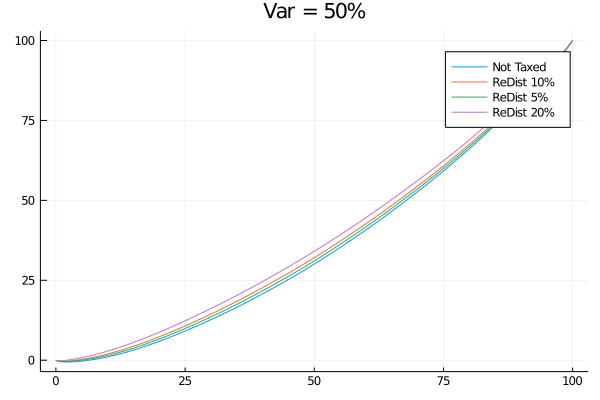

In [7]:
# Part B with Taxation
# 1 
function ReDist(arr,per) 
    ar = copy(arr) 
    N, = size(ar) 
    Ret = sum(per*i for i in ar)/N 
    ar *= 1-per 
    ar = ar.+ Ret 
    return ar 
end 
N = 1000 
x= range(0,100,length=N) 
arr = gen_income(Normal(1000,500),1000) 
co1,L1 = cal_Gini(arr)
plot(x , L1,label="Not Taxed",title = "Var = 50%")

ar = ReDist(arr,.1) 
co2,L2 = cal_Gini(ar) 
plot!(x , L2,label="ReDist 10% ")
# mean(ar) ≈ mean(arr)
#2 

ar = ReDist(arr,.05) 
co2,L2 = cal_Gini(ar) 
plot!(x , L2,label="ReDist 5% ")

ar = ReDist(arr,.20) 
co2,L2 = cal_Gini(ar) 
plot!(x , L2,label="ReDist 20% ")

In [ ]:
#3 
function Step_Tax(arr,rates)
    summ = similar(arr)
    ar = sort(arr)
    N, = size(ar)
    d = Int(N/10)
    for i in 1:10
        j= i*d
        summ[j-d+1:j-1] = (ar[j-d+1:j-1] * rates[i]) 
        ar[j-d+1:j-1] *= 1-rates[i]
    end
    T = sum(summ)
    Ret = T/N
    ar = ar.+ Ret
    return ar
end
#4
function Step_Tax_Dec(arr,Rates)
    rates= copy(Rates)
    summ = similar(arr)
    ar = sort(arr)
    N, = size(ar)
    d = Int(N/10)
    for i in 1:10
        j= i*d
        summ[j-d+1:j-1] = (ar[j-d+1:j-1] * rates[i]) 
        ar[j-d+1:j-1] *= 1-rates[i]
    end
    T = sum(summ)
    Rev_rates = reverse(rates)
    for i in 1:10
        j= i*d
        ar[j-d+1:j-1] = ar[j-d+1:j-1] .+ (T*Rev_rates[i])/d
    end
    return ar
end
N = 1000 
x= range(0,100,length=N) 
arr = gen_income(Normal(1000,500),N)
co1,L1 = cal_Gini(copy(arr))
Rates = [0,0,5,5,10,10,15,15,20,20]/100
ar2 = Step_Tax(copy(arr),Rates) 
co2,L2 = cal_Gini(ar2) 
ar3 = Step_Tax_Dec(copy(arr),Rates) 
co3,L3 = cal_Gini(ar3)

println("GINI COEFFs:  Not Taxed:$co1 \t StepTax$co2 \t StepTax: $co3")
plot(x , L1,label="Not Taxed",title = "Var = 50%")
plot!(x , L2,label="StepTax ")
plot!(x , L3,label="StepTaxDEC  ")